# SHO Fitting Data

## Import Packages

In [9]:
import sys
sys.path.append('../../')
sys.path.append('/home/ferroelectric/m3_learning/m3_learning/src')

In [10]:
%load_ext autoreload
# import gdown
import time
import h5py
import pyUSID as usid
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import style
from m3_learning.be.util import print_be_tree
from m3_learning.be.processing import convert_amp_phase, fit_loop_function, SHO_Fitter, SHO_fit_to_array, loop_lsqf
from m3_learning.viz.layout import layout_fig
from m3_learning.util.h5_util import make_dataset, make_group
from m3_learning.util.file_IO import download_and_unzip
from m3_learning.viz.printing import printer
printing = printer(basepath = './figures/')

from scipy.signal import resample
from scipy import fftpack


style("default")
random_seed(seed=42)

%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
default set for matplotlib
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loading data for SHO fitting


In [11]:
path = r"./"

In [12]:
# Download the data file from Zenodo
url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'

# Specify the filename and the path to save the file
filename = 'data_file_raw.h5'
save_path = './'

# download the file
download_and_unzip(filename, url, save_path)

downloading data
...100%, 1663 MB, 3278 KB/s, 519 seconds passed

In [13]:
from m3_learning.util.h5_util import print_tree
from BGlib import be as belib
import pyUSID as usid
import os
import sidpy
import numpy as np

class BE_Dataset:
    
    def __init__(self, dataset):
        
        self.dataset = dataset
        
    def print_be_tree(self):
        """Utility file to print the Tree of a BE Dataset

        Args:
            path (str): path to the h5 file
        """
        
        with h5py.File(self.dataset, "r+") as h5_f:

            # Inspects the h5 file
            usid.hdf_utils.print_tree(h5_f)

            # prints the structure and content of the file
            print("Datasets and datagroups within the file:\n------------------------------------")
            print_tree(h5_f.file)

            print("\nThe main dataset:\n------------------------------------")
            print(h5_f)
            print("\nThe ancillary datasets:\n------------------------------------")
            print(h5_f.file["/Measurement_000/Channel_000/Position_Indices"])
            print(h5_f.file["/Measurement_000/Channel_000/Position_Values"])
            print(h5_f.file["/Measurement_000/Channel_000/Spectroscopic_Indices"])
            print(h5_f.file["/Measurement_000/Channel_000/Spectroscopic_Values"])

            print("\nMetadata or attributes in a datagroup\n------------------------------------")
            for key in h5_f.file["/Measurement_000"].attrs:
                print("{} : {}".format(key, h5_f.file["/Measurement_000"].attrs[key]))
                
    def SHO_Fitter(self, force=False, max_cores=-1, max_mem=1024*8):
        """Function that computes the SHO fit results

        Args:
            force (bool, optional): forces the SHO results to be computed from scratch. Defaults to False.
            max_cores (int, optional): number of processor cores to use. Defaults to -1.
            max_mem (_type_, optional): maximum ram to use. Defaults to 1024*8.
        """

        start_time_lsqf = time.time()

        (data_dir, filename) = os.path.split(self.dataset)

        if self.dataset.endswith(".h5"):
            # No translation here
            h5_path = self.dataset

            tl = belib.translators.LabViewH5Patcher()
            tl.translate(h5_path, force_patch=force)

        else:
            pass

        folder_path, h5_raw_file_name = os.path.split(h5_path)
        h5_file = h5py.File(h5_path, "r+")
        print("Working on:\n" + h5_path)

        h5_main = usid.hdf_utils.find_dataset(h5_file, "Raw_Data")[0]

        h5_pos_inds = h5_main.h5_pos_inds
        pos_dims = h5_main.pos_dim_sizes
        pos_labels = h5_main.pos_dim_labels
        print(pos_labels, pos_dims)

        h5_meas_grp = h5_main.parent.parent

        parm_dict = sidpy.hdf_utils.get_attributes(h5_meas_grp)

        expt_type = usid.hdf_utils.get_attr(h5_file, "data_type")

        is_ckpfm = expt_type == "cKPFMData"
        if is_ckpfm:
            num_write_steps = parm_dict["VS_num_DC_write_steps"]
            num_read_steps = parm_dict["VS_num_read_steps"]
            num_fields = 2

        if expt_type != "BELineData":
            vs_mode = usid.hdf_utils.get_attr(h5_meas_grp, "VS_mode")
            try:
                field_mode = usid.hdf_utils.get_attr(
                    h5_meas_grp, "VS_measure_in_field_loops")
            except KeyError:
                print("field mode could not be found. Setting to default value")
                field_mode = "out-of-field"
            try:
                vs_cycle_frac = usid.hdf_utils.get_attr(
                    h5_meas_grp, "VS_cycle_fraction")
            except KeyError:
                print("VS cycle fraction could not be found. Setting to default value")
                vs_cycle_frac = "full"

        sho_fit_points = 5  # The number of data points at each step to use when fitting
        sho_override = force  # Force recompute if True

        h5_sho_targ_grp = None
        h5_sho_file_path = os.path.join(
            folder_path, h5_raw_file_name)

        print("\n\nSHO Fits will be written to:\n" + h5_sho_file_path + "\n\n")
        f_open_mode = "w"
        if os.path.exists(h5_sho_file_path):
            f_open_mode = "r+"
        h5_sho_file = h5py.File(h5_sho_file_path, mode=f_open_mode)
        h5_sho_targ_grp = h5_sho_file

        sho_fitter = belib.analysis.BESHOfitter(
            h5_main, cores=max_cores, verbose=False, h5_target_group=h5_sho_targ_grp
        )
        sho_fitter.set_up_guess(
            guess_func=belib.analysis.be_sho_fitter.SHOGuessFunc.complex_gaussian,
            num_points=sho_fit_points,
        )
        h5_sho_guess = sho_fitter.do_guess(override=sho_override)
        sho_fitter.set_up_fit()
        h5_sho_fit = sho_fitter.do_fit(override=sho_override)
        parms_dict = parms_dict = sidpy.hdf_utils.get_attributes(
            h5_main.parent.parent)

        print(
            f"LSQF method took {time.time() - start_time_lsqf} seconds to compute parameters")
        
    @property
    def num_bins(self):
        """Number of frequency bins in the data"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["num_bins"]
    
    @property
    def num_pix(self):
        """Number of pixels in the data"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["num_pix"]
    
    @property
    def num_pix_1d(self):
        """Number of pixels in the data"""
        with h5py.File(self.dataset, "r") as h5_f:
            return int(np.sqrt(self.num_pix))
    
    @property
    def voltage_steps(self):
        """Number of DC voltage steps"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["num_udvs_steps"]

    @property
    def sampling_rate(self):
        """Sampling rate in Hz"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["IO_rate_[Hz]"]
        
    @property
    def be_bandwidth(self):
        """BE bandwidth in Hz"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["BE_band_width_[Hz]"]

    @property
    def be_center_frequency(self):
        """BE center frequency in Hz"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"].attrs["BE_center_frequency_[Hz]"]
        
    @property
    def frequency_bin(self):
        """Frequency bin vector in Hz"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"]
        
    @property
    def wvec_freq(self, bins = 80):
        """Resampled frequency vector in Hz"""
        with h5py.File(self.dataset, "r") as h5_f:
            try:
                return self._wvec_freq
            except:
                self.wvec_freq = bins
                return self._wvec_freq

    @wvec_freq.setter
    def wvec_freq(self, bins):
        self._wvec_freq = resample(self.frequency_bin, bins)
        
    @property
    def be_waveform(self):
        """BE excitation waveform"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Excitation_Waveform"]
        
    @property
    def spectroscopic_values(self):
        """Spectroscopic values"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Spectroscopic_Values"]
        
    @property
    def raw_data(self):
        """Raw data"""
        with h5py.File(self.dataset, "r") as h5_f:
            return h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]
        
        
    @property
    def shape(self):
        """Shape of the raw data"""
        with h5py.File(self.dataset, "r") as h5_f:
            return self.raw_data.shape
        
    @property
    def complex_data(self):
        """Complex data"""
        with h5py.File(self.dataset, "r") as h5_f:
            try:
                return self._complex_data
            except:
                self.complex_data = None
                return self._complex_data
                
    @complex_data.setter
    def complex_data(self, a = None):
        with h5py.File(self.dataset, "r+") as h5_f:
            make_group(h5_f["Measurement_000"]["Channel_000"], 'complex')
            make_dataset(h5_f["Measurement_000"]["Channel_000"]['complex'], 'real', np.real(
                self.raw_data))
            make_dataset(h5_f["Measurement_000"]["Channel_000"]['complex'], 'imag', np.imag(
                self.raw_data))
            self._complex_data = h5_f["Measurement_000"]["Channel_000"]['complex']
        
    @property
    def amplitude_phase(self):
        with h5py.File(self.dataset, "r") as h5_f:
            try:
                return self._amplitude_phase
            except:
                self.amplitude_phase = None
                return self._amplitude_phase
            
    @amplitude_phase.setter
    def amplitude_phase(self, a = None):
        with h5py.File(self.dataset, "r+") as h5_f:
            make_group(h5_f["Measurement_000"]["Channel_000"], 'amplitude_phase')
            make_dataset(h5_f["Measurement_000"]["Channel_000"]['amplitude_phase'], 'amplitude', np.abs(
                self.raw_data))
            make_dataset(h5_f["Measurement_000"]["Channel_000"]['amplitude_phase'], 'phase', np.angle(
                self.raw_data))
            self._amplitude_phase = h5_f["Measurement_000"]["Channel_000"]['amplitude_phase']
    
# # creates the necessary structure in the H5_file
# make_group(h5_f["Measurement_000"]["Channel_000"], 'magn_spec')



# # converts the raw data to amplitude and phase
# amp, phase = convert_amp_phase(raw_data)

# # Makes the amplitude and phase datasets and saves it to the H5 file
# make_dataset(h5_f["Measurement_000"]["Channel_000"]['magn_spec'], 'amp', amp)
# make_dataset(h5_f["Measurement_000"]["Channel_000"]
#              ['magn_spec'], 'phase', phase)


Prints the Tree to show the Data Structure

In [14]:
# instantiate the dataset object
dataset = BE_Dataset(path + "data_file_raw.h5")

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
Datasets and datagroups within the file:
------------------------------------
/
/Measurement_000
/Measurement_000/Channel_000
/Measurement_000/Channel_000/Bin_FFT
/Measurement_000/Chann

## SHO Fitting
**Note**: this code takes around 15 minutes to execute

In [15]:
# computes the SHO fit for the data in the file
dataset.SHO_Fitter()

File is already Pycroscopy ready.
Working on:
./data_file_raw.h5
['Y', 'X'] [60, 60]


SHO Fits will be written to:
./data_file_raw.h5


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file
	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a Jupyter notebook, click on "Kernel">>"Interrupt"
	If you are operating on a cluster and your job gets killed, re-run the job to resume

Rank 0 - 100% complete. Time remaining: 0.0 msec
Finished processing the entire dataset!

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000" (4 members)>]


/home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/BGlib/be/analysis/fitter.py:140: UserWarning: status dataset not created yet
  warn('status dataset not created yet')
/home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/BGlib/be/analysis/fitter.py:140: UserWarning: status dataset not created yet
  warn('status dataset not created yet')


Resuming computation. 0% completed already
	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a Jupyter notebook, click on "Kernel">>"Interrupt"
	If you are operating on a cluster and your job gets killed, re-run the job to resume

Rank 0 - 100% complete. Time remaining: 0.0 msec
Finished processing the entire dataset!
LSQF method took 1821.9747519493103 seconds to compute parameters


### Saves the Data

In [16]:
dataset.complex_data

ValueError: Invalid dataset identifier (invalid dataset identifier)

could not add group - it might already exist
could not add group - it might already exist


### Visualize Raw Data

3092 6
Number of time steps: 4096.0


C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


./figures/Figure_1_random_cantilever_resonance_results.png
./figures/Figure_1_random_cantilever_resonance_results.svg


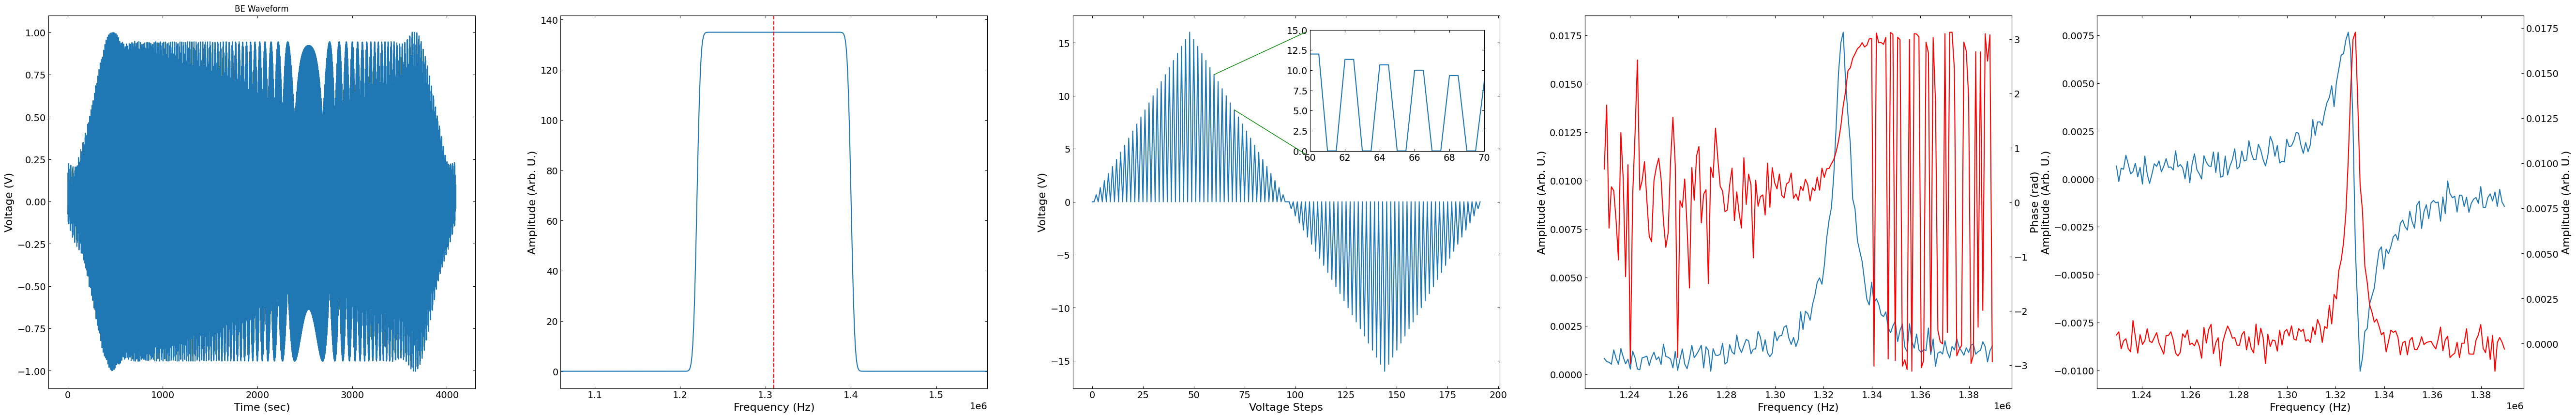

In [21]:
# Select a random point and time step to plot
pixel = np.random.randint(0,h5_f["Measurement_000"]["Channel_000"]['magn_spec']['amp'][:].shape[0])
timestep = np.random.randint(h5_f["Measurement_000"]["Channel_000"]['magn_spec']['amp'][:].shape[0]/num_bins)
print(pixel, timestep)

# Plots the amplitude and phase for the selected pixel and time step
fig, ax = layout_fig(5, 5, figsize=(6 * 11, 10))

# constructs the BE waveform and plot
be_timesteps = len(be_waveform) / 4
print("Number of time steps: " + str(be_timesteps))
ax[0].plot(be_waveform[: int(be_timesteps)])
ax[0].set(xlabel="Time (sec)", ylabel="Voltage (V)")
ax[0].set_title("BE Waveform")

# plots the resonance graph
resonance_graph = np.fft.fft(be_waveform[: int(be_timesteps)])
fftfreq = fftpack.fftfreq(int(be_timesteps)) * sampling_rate
ax[1].plot(
    fftfreq[: int(be_timesteps) // 2], np.abs(resonance_graph[: int(be_timesteps) // 2])
)
ax[1].axvline(
    x=be_center_frequency,
    ymax=np.max(resonance_graph[: int(be_timesteps) // 2]),
    linestyle="--",
    color="r",
)
ax[1].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax[1].set_xlim(
    be_center_frequency - be_bandwidth - be_bandwidth * 0.25,
    be_center_frequency + be_bandwidth + be_bandwidth * 0.25,
)

hysteresis_waveform = (
    spectroscopic_values[1, ::165][192:] * spectroscopic_values[2, ::165][192:]
)


# manually set the x limits
x_start = 120
x_end = 140

ax[2].plot(hysteresis_waveform)
ax_new = fig.add_axes([0.52, 0.6, 0.3/5.5, 0.25])
ax_new.plot(np.repeat(hysteresis_waveform, 2))
ax_new.set_xlim(x_start, x_end)
ax_new.set_ylim(0, 15)
ax_new.set_xticks(np.linspace(x_start, x_end, 6))
ax_new.set_xticklabels([60, 62, 64, 66, 68, 70])
fig.add_artist(
    ConnectionPatch(
        xyA=(x_start // 2, hysteresis_waveform[x_start // 2]),
        coordsA=ax[2].transData,
        xyB=(105, 16),
        coordsB=ax[2].transData,
        color="green",
    )
)
fig.add_artist(
    ConnectionPatch(
        xyA=(x_end // 2, hysteresis_waveform[x_end // 2]),
        coordsA=ax[2].transData,
        xyB=(105, 4.5),
        coordsB=ax[2].transData,
        color="green",
    )
)
ax[2].set_xlabel("Voltage Steps")
ax[2].set_ylabel("Voltage (V)")

# plots the magnitude spectrum for and phase for the selected pixel and time step
ax[3].plot(
    frequency_bin,
    h5_f["Measurement_000"]["Channel_000"]['magn_spec']['amp'][:].reshape(num_pix, -1, num_bins)[pixel, timestep],
)
ax[3].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax2 = ax[3].twinx()
ax2.plot(
    frequency_bin,
    h5_f["Measurement_000"]["Channel_000"]['magn_spec']['phase'][:].reshape(num_pix, -1, num_bins)[pixel, timestep],
    "r",
)
ax2.set(xlabel="Frequency (Hz)", ylabel="Phase (rad)");

# plots the real and imaginary components for the selected pixel and time step
ax[4].plot(frequency_bin, h5_f["Measurement_000"]["Channel_000"]['complex']['real'][pixel].reshape(-1, num_bins)[timestep], label="Real")
ax[4].set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)")
ax3 = ax[4].twinx()
ax3.plot(
    frequency_bin, h5_f["Measurement_000"]["Channel_000"]['complex']['imag'][pixel].reshape(-1, num_bins)[timestep],'r', label="Imaginary")
ax3.set(xlabel="Frequency (Hz)", ylabel="Amplitude (Arb. U.)");

printing.savefig(figs, "Figure_1_random_cantilever_resonance_results")

### Plots the SHO Fit Results

In [22]:
# extracts the dc voltage values this removes the 0 values which are measurement points
dc_voltage = h5_f["Measurement_000"]["Channel_000"]['Raw_Data-SHO_Fit_000']['Spectroscopic_Values'][0,1::2]

# extracts the SHO fit results
SHO_fit_results = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

./figures/Figure_2_random_SHO_fit_results.png
./figures/Figure_2_random_SHO_fit_results.svg


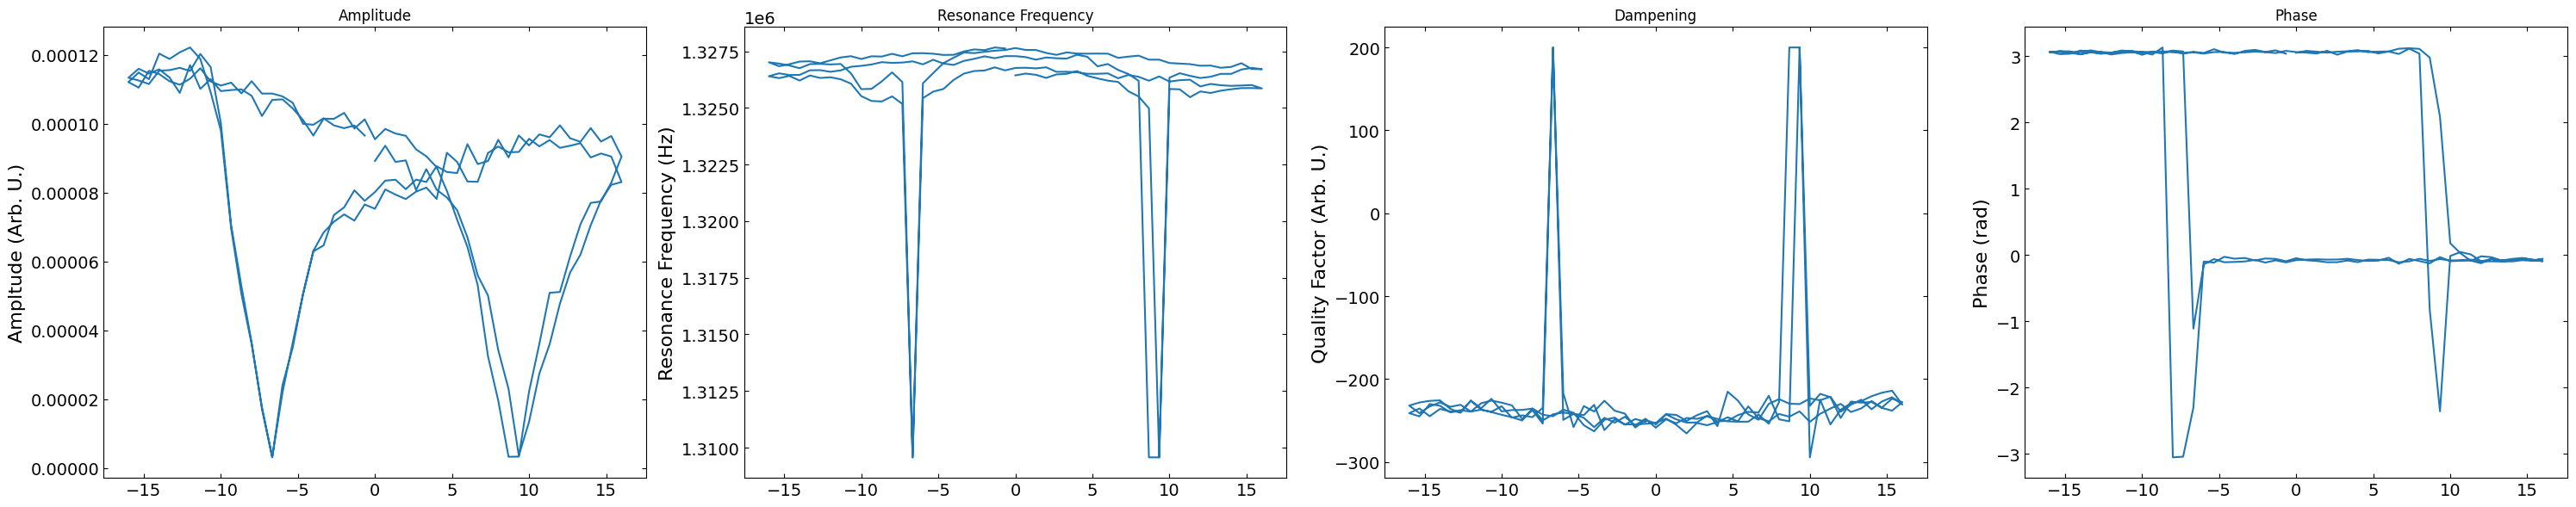

In [23]:
# selects a random pixel to plot
pix = np.random.randint(0,3600)

# plots the SHO fit results for the selected pixel
figs, ax = layout_fig(4, 4, figsize=(30, 6))

# labels for the plots
labels = [{'title': "Amplitude",
            'y_label': "Ampltude (Arb. U.)"},
         {'title': "Resonance Frequency",
            'y_label': "Resonance Frequency (Hz)"},
         {'title': "Dampening",
            'y_label': "Quality Factor (Arb. U.)"},
        {'title': "Phase",
            'y_label': "Phase (rad)"}]

for i, ax in enumerate(ax):
    ax.plot(dc_voltage, SHO_fit_results[pix,1::2,i])
    ax.set_title(labels[i]['title'])
    ax.set_ylabel(labels[i]['y_label'])
    
figs.tight_layout()
printing.savefig(figs, "Figure_2_random_SHO_fit_results")

### Visualize the SHO Fit Results

In [24]:
# extracts the fit results from an H5 file
fit_results_list = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

# flatten parameters list into numpy array
fit_results_list = np.array(fit_results_list).reshape(num_pix, voltage_steps, 5)

./figures/Figure_3_SHO_fit_results_before_scaling.png
./figures/Figure_3_SHO_fit_results_before_scaling.svg


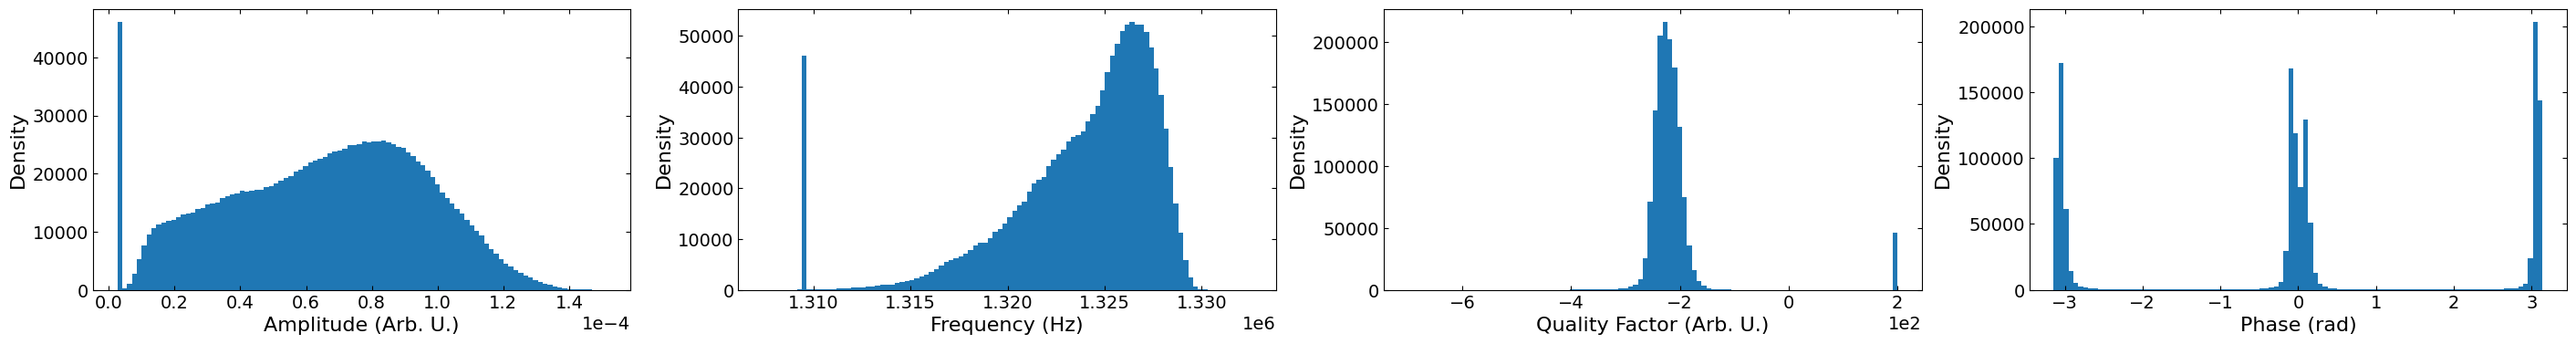

In [25]:
# check distributions of each parameter before and after scaling
fig, axs = layout_fig(4, 4, figsize=(35, 4))

# defines the units for each parameter
units = [
    "Amplitude (Arb. U.)",
    "Frequency (Hz)",
    "Quality Factor (Arb. U.)",
    "Phase (rad)",
]

# plots the distributions of each parameter before scaling
for i in range(4):
    axs[i].hist(fit_results_list[:, :, i].flatten(), 100)


for i, ax in enumerate(axs.flat):
    ax.set(xlabel=units[i], ylabel="Density")
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    
printing.savefig(figs, "Figure_3_SHO_fit_results_before_scaling")

In [ ]:
# Closes the h5_file
h5_f.close()